In [1]:
import os
import spacy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor


nlp = spacy.load("fr_core_news_md")
nlp.max_length = 100000000

pronoms = {
    "1st_sing": {"je", "j'", "me", "m'", "moi", "mon", "mes"},
    "2nd_sing": {"tu", "t'", "te", "t'", "toi", "ton", "ta", "tes"},
    "3rd_sing": {"il", "elle", "lui", "soi", "se", "son", "sa", "ses"},
    "1st_plur": {"nous", "notre", "nos"},
    "2nd_plur": {"vous", "votre", "vos"},
    "3nd_plur": {"ils", "elles", "eux", 'leurs'}
}

def process_file(file):

    with open(os.path.join(path, file), 'r') as f:
        texte = f.read()
        
    doc = nlp(texte, disable=['parser', 'ner'])
    size = len(doc)
    pronom_stats = {pronom: 0 for pronom in pronoms}
    sentence_stats = {'Affirmative': 0, 'Interrogative': 0, 'Exclamative': 0}


    for token in doc:
        if token.pos_ == "PRON":
            lower_text = token.text.lower()
            for pronom, pronom_set in pronoms.items():
                if lower_text in pronom_set:
                    pronom_stats[pronom] += 1
                    
    
    pronomsf = {}
    
    for k, v in pronom_stats.items():
        pronomsf[k]=(v/size)*100
        

    return pronomsf

def process_files_in_parallel(files):
    results = {}
    
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_file, file) for file in files]
        
        for idx, future in enumerate(futures):
            file = files[idx]
            stats = future.result()
            results[file] = stats
    
    return results

path = './data/genre'
files = os.listdir(path)

num_cores = 8
files_per_core = len(files) // num_cores
file_groups = [files[i:i+files_per_core] for i in range(0, len(files), files_per_core)]

all_results = {}
for group in file_groups:
    results = process_files_in_parallel(group)
    all_results.update(results)

df = pd.DataFrame.from_dict(all_results, orient='index')
part1_list, part2_list, part3_list = [], [], []

for string in df.index.str.split('_'):
    parts = string
    part1_list.append(parts[0])
    part2_list.append(parts[1])
    part3_list.append(parts[2].replace('.txt',''))

df.index = pd.MultiIndex.from_arrays([part1_list, part2_list, part3_list], names=('Genre', 'Auteur', 'Titre'))
df

1st_sing  \
Genre    Auteur   Titre                                                          
pamphlet Bernanos La liberté, pour quoi faire                         0.977816   
         Chirac   Les rois de la République I                         0.648456   
essai    Bloy     Le Sang du pauvre                                   0.448998   
         Péguy    Note sur M. Bergson et la philosophie bergsonienne  0.507038   
         Daudet   Les Œuvres dans les hommes                          0.586008   
...                                                                        ...   
roman    Barrès   La Colline inspirée                                 0.332676   
pamphlet Chirac   Les pots de vin parlementaires                      0.983284   
roman    Céline   Voyage au bout de la nuit                           2.725733   
essai    Daudet   Bréviaire du journalisme                            0.912537   
roman    Barrès   Le quartier latin                                   0.776130   

                                                                      2nd_sing  \
Genre    Auteur   Titre                                                          
pamphlet Bernanos La liberté, pour quoi faire                         0.005813   
         Chirac   Les rois de la République I                         0.034882   
essai    Bloy     Le Sang du pauvre                                   0.195717   
         Péguy    Note sur M. Bergson et la philosophie bergsonienne  0.010484   
         Daudet   Les Œuvres dans les hommes                          0.019447   
...                                                                        ...   
roman    Barrès   La Colline inspirée                                 0.035857   
pamphlet Chirac   Les pots de vin parlementaires                      0.000000   
roman    Céline   Voyage au bout de la nuit                           0.311234   
essai    Daudet   Bréviaire du journalisme                            0.025270   
roman    Barrès   Le quartier latin                                   0.017247   

                                                                      3rd_sing  \
Genre    Auteur   Titre                                                          
pamphlet Bernanos La liberté, pour quoi faire                         2.227700   
         Chirac   Les rois de la République I                         2.188652   
essai    Bloy     Le Sang du pauvre                                   1.905365   
         Péguy    Note sur M. Bergson et la philosophie bergsonienne  2.933580   
         Daudet   Les Œuvres dans les hommes                          2.214386   
...                                                                        ...   
roman    Barrès   La Colline inspirée                                 2.623558   
pamphlet Chirac   Les pots de vin parlementaires                      1.930813   
roman    Céline   Voyage au bout de la nuit                           2.860069   
essai    Daudet   Bréviaire du journalisme                            1.660817   
roman    Barrès   Le quartier latin                                   1.379786   

                                                                      1st_plur  \
Genre    Auteur   Titre                                                          
pamphlet Bernanos La liberté, pour quoi faire                         0.673193   
         Chirac   Les rois de la République I                         0.074237   
essai    Bloy     Le Sang du pauvre                                   0.236012   
         Péguy    Note sur M. Bergson et la philosophie bergsonienne  0.380279   
         Daudet   Les Œuvres dans les hommes                          0.228180   
...                                                                        ...   
roman    Barrès   La Colline inspirée                                 0.229088   
pamphlet Chirac   Les pots de vin parlementaires                      0.098328   
roman    Céline   Voyage au bout de la nuit      

In [52]:
import os
import spacy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from spacy.matcher import Matcher

# Chargez le modèle spaCy (assurez-vous d'avoir installé spaCy et téléchargé un modèle de langue, par exemple "fr_core_news_md" pour le français)
nlp = spacy.load("fr_core_news_md")
nlp.max_length = 100000000

# Créez un objet Matcher
matcher = Matcher(nlp.vocab)
patterns = [
    [{"POS": {"in": ["PRON"]}}, {"POS": {"in": ["VERB"]}}, {"POS": {"in": ["PRON"]}}],
    [{"POS": {"in": ["PRON"]}}, {"POS": {"in": ["PRON"]}}, {"POS": {"in": ["VERB"]}}],
]
matcher.add("pron_matcher", patterns)

def process_file(file):
    with open(os.path.join(path, file), 'r') as f:
        texte = f.read()
        
    doc = nlp(texte, disable=['parser', 'ner'])
    size = len(doc)
    pronom_stats = {}

    matches = matcher(doc)
    
    for ms in matches:

        token_ids = ms[1:]  
        matched_tokens = [doc[token_id].text for token_id in token_ids]

        pronom_stats["pronom_sequences"] = matched_tokens

    
    return pronom_stats

def process_files_in_parallel(files):
    results = {}
    
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_file, file) for file in files]
        
        for idx, future in enumerate(futures):
            file = files[idx]
            stats = future.result()
            results[file] = stats
    
    return results

path = './data/genre'
files = os.listdir(path)

num_cores = 8
files_per_core = len(files) // num_cores
file_groups = [files[i:i+files_per_core] for i in range(0, len(files), files_per_core)]

# À la fin du traitement de tous les fichiers, vous pouvez créer un DataFrame à partir des données de la matrice de confusion
all_results = {}
for group in file_groups:
    results = process_files_in_parallel(group)
    for file, stats in results.items():
        for key, value in stats.items():
            if key not in all_results:
                all_results[key] = 0
            all_results[key] += value

# Créez un DataFrame à partir des données de la matrice de confusion
df = pd.DataFrame.from_dict(all_results, orient='index', columns=['Occurrences'])
df.reset_index(inplace=True)
df.rename(columns={'index': 'Motif'}, inplace=True)
df.sort_values(by='Occurrences', ascending=False, inplace=True)
print(df)



IndexError: [E040] Attempt to access token at 104923, max length 104923.

In [46]:
nombre_minimum_valeurs_non_vides = 200
nombre_valeurs_non_vides_par_colonne = df.count()
colonnes_a_garder = nombre_valeurs_non_vides_par_colonne[nombre_valeurs_non_vides_par_colonne >= nombre_minimum_valeurs_non_vides].index
df.loc[:, colonnes_a_garder]

,qui,où,il,ce,dont,nous,le,se,elle,ils,on,en,y,que,je,les,vous
0,0.848758,0.120919,1.008046,0.410427,0.161613,0.673193,0.218584,0.577853,0.440657,0.419728,0.433681,0.277881,0.302297,0.202307,0.732490,0.127895,0.594131
1,0.644879,0.109120,1.349683,0.238811,0.140424,0.074237,0.129691,0.403384,0.152052,0.201245,0.534865,0.202139,0.210189,0.135058,0.365819,0.079604,0.143108
2,1.197329,0.141032,1.203085,0.319480,0.138153,0.236012,0.224499,0.302210,0.161179,0.256159,0.618812,0.279185,0.411582,0.175570,0.313723,0.178448,0.394313
3,1.181819,0.130572,1.815617,0.557552,0.047654,0.380279,0.135337,0.369795,0.559458,0.331672,0.732918,0.236364,0.463197,0.211584,0.324047,0.095308,0.097214
4,0.737696,0.207437,1.427423,0.219105,0.116683,0.228180,0.154281,0.343567,0.110201,0.092050,0.311155,0.180211,0.200954,0.133537,0.398019,0.055749,0.136130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,0.964630,0.336855,1.806768,0.260297,0.107181,1.025877,0.199051,0.505282,0.091870,0.382790,0.336855,0.045935,0.214362,0.137804,0.367478,0.122493,0.168427
199,0.763359,0.289151,0.532038,0.161925,0.138793,0.323849,0.115660,0.185057,0.219755,0.069396,0.289151,0.069396,0.034698,0.080962,0.161925,0.046264,0.092528
200,0.845547,0.394589,2.254791,0.169109,0.169109,1.127396,0.112740,0.450958,0.056370,0.056370,0.112740,0.112740,0.281849,0.112740,0.563698,NaN,NaN
201,0.230947,0.230947,0.769823,0.615858,NaN,0.538876,0.076982,0.384911,0.153965,0.307929,0.230947,0.230947,0.230947,0.307929,0.461894,0.153965,0.153965


In [3]:
def grouping(df, group):
    # Somme par groupe d'index en l'occurence ici les Genres
    alle = {}
    for genre in df.index.get_level_values(group).unique():
        genre_df = df[df.index.get_level_values(group) == genre]
        alle[genre] = genre_df.mean() # je veux diviser la somme par le nombre de ligne, est-ce le bon code ?

    genres_df = pd.DataFrame.from_dict(alle, orient='index')
    return genres_df

#df1 = df[df.index.get_level_values('Auteur') == 'Barrès']

genre_df = grouping(df,'Genre')
df_styled = genre_df.style.background_gradient(cmap='viridis')
df_styled

,1st_sing,2nd_sing,3rd_sing,1st_plur,2nd_plur,3nd_plur
pamphlet,0.749109,0.054504,1.684366,0.401491,0.335584,0.443465
essai,0.777793,0.059348,1.952737,0.276060,0.306188,0.289265
roman,1.663160,0.175433,2.454260,0.406798,0.452869,0.376504
article,0.581370,0.121678,1.892503,0.408673,0.239192,0.393084
nouvelle,1.446776,0.229057,2.379935,0.226576,0.377573,0.227935
journal,2.381015,0.063406,1.527685,0.346168,0.667608,0.128039
mémoire,1.333534,0.019698,1.819831,0.383885,0.250271,0.168495
correspondance,3.113554,0.793224,1.273002,0.476429,0.788827,0.157145
biographie,0.953972,0.254230,2.684145,0.238607,0.180725,0.177070
discours,0.562527,0.022404,1.807231,0.866314,0.330028,0.366922


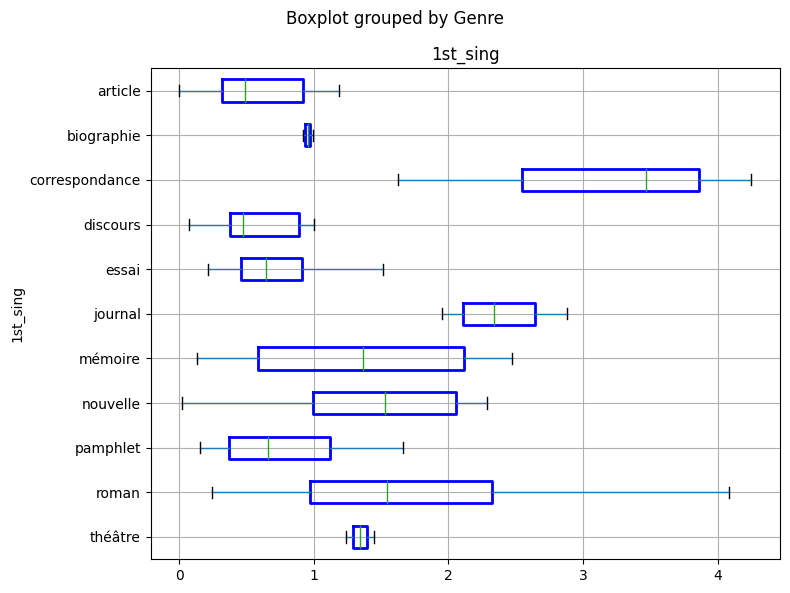

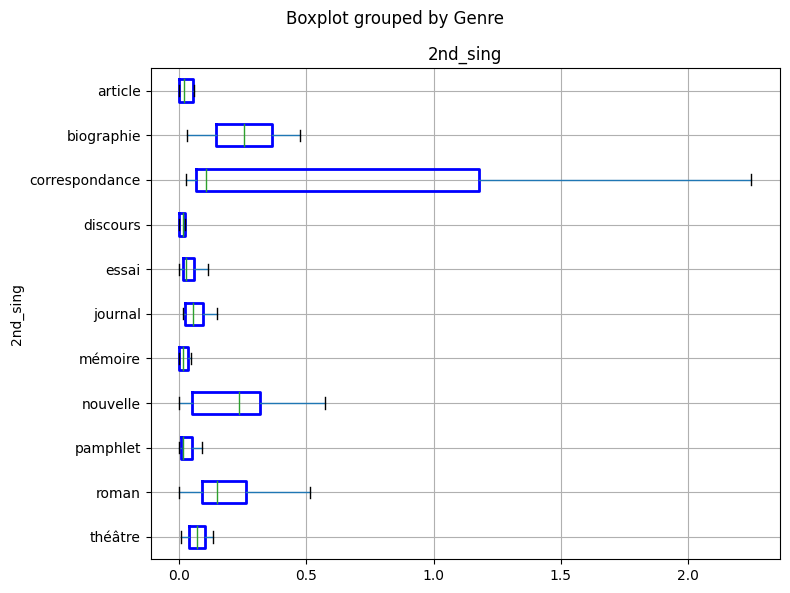

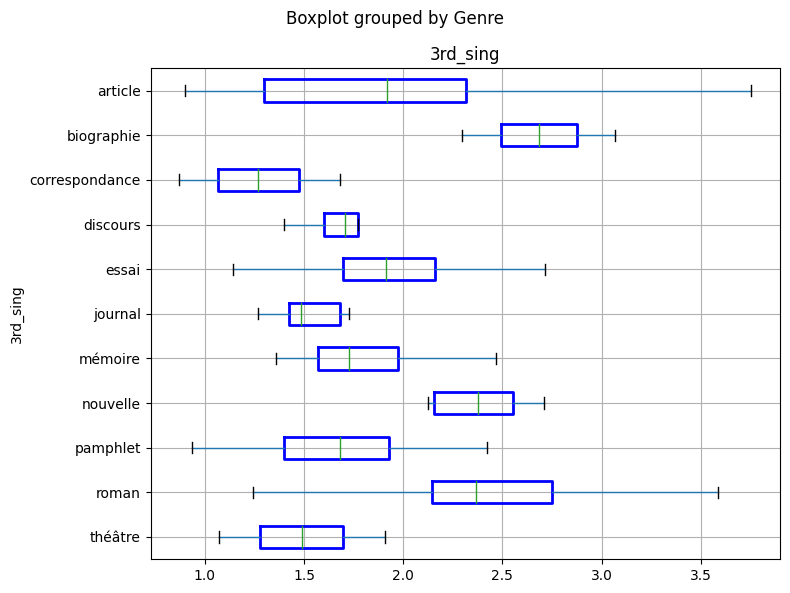

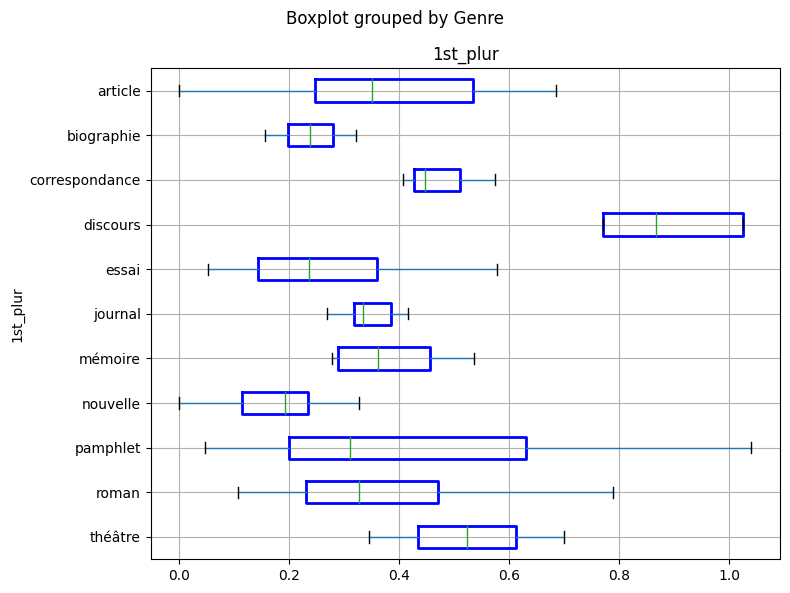

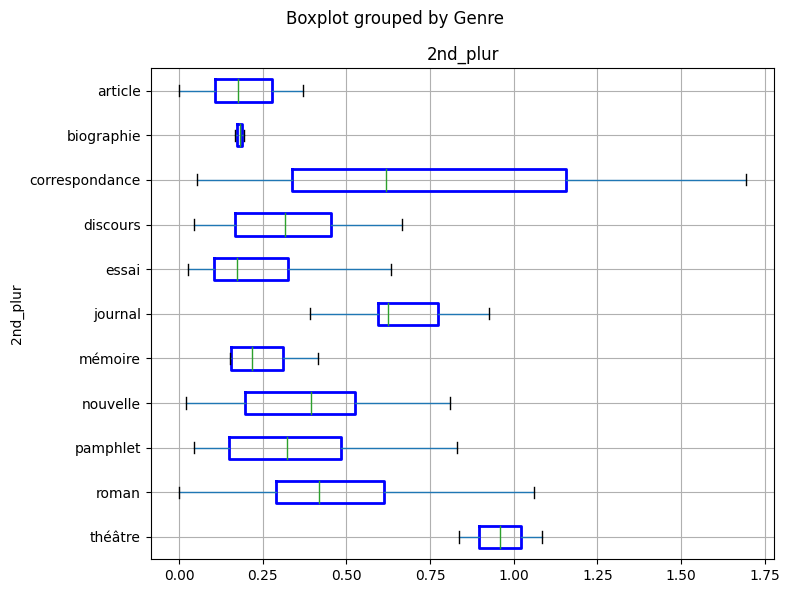

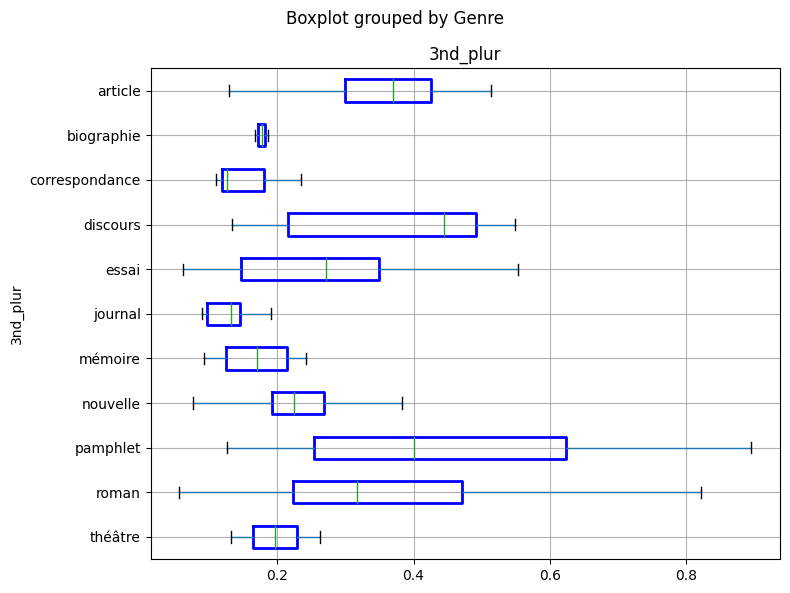

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supposons que vous ayez un DataFrame 'df' contenant vos données

# Liste des colonnes à inclure dans le graphique en boîte
columns_to_plot = df.columns

# Propriétés des boîtes du graphique en boîte
boxprops = dict(linestyle='-', linewidth=2, color='b')

# Parcourir les colonnes et créer un graphique en boîte pour chaque colonne
for col in columns_to_plot:
    fig, ax = plt.subplots(figsize=(8, 6))
    df[[col]].boxplot(by='Genre', vert=False, ax=ax, boxprops=boxprops, showfliers=False)
    ax.set_ylabel(col)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# Supposons que vous ayez déjà défini votre DataFrame df et la colonne 'Genre'

for genre, sub_df in df.groupby('Genre'):
    print(f"Sous-DataFrame pour le genre {genre}:\n")
    
    # Utilisation d'une carte de couleur séquentielle
    cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez
    
    def color_map(val):
        min_val = sub_df.min().min()
        max_val = sub_df.max().max()
        gradient = (val - min_val) / (max_val - min_val)
        rgba_color = cmap(gradient)  # Utilisez la carte de couleur pour obtenir la couleur séquentielle
        rgba_color = [int(255 * c) for c in rgba_color]
        color = f'rgba({rgba_color[0]}, {rgba_color[1]}, {rgba_color[2]}, {rgba_color[3]})'
        return f'background-color: {color};'

    styled_df = sub_df.style.applymap(color_map)
    display(styled_df)
    print("-" * 80)


Sous-DataFrame pour le genre article:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
Sous-DataFrame pour le genre biographie:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
Sous-DataFrame pour le genre correspondance:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
Sous-DataFrame pour le genre discours:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
Sous-DataFrame pour le genre essai:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
Sous-DataFrame pour le genre journal:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
Sous-DataFrame pour le genre mémoire:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
Sous-DataFrame pour le genre nouvelle:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
Sous-DataFrame pour le genre pamphlet:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
Sous-DataFrame pour le genre roman:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
Sous-DataFrame pour le genre théâtre:



/tmp/ipykernel_90866/3891681170.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choisissez la carte de couleur que vous souhaitez


--------------------------------------------------------------------------------
